# The seasonal cycle of surface temperature

Look at the observed seasonal cycle in the NCEP reanalysis data.

Read in the necessary data from the online server *courtesy of the [NOAA Physical Sciences Laboratory](https://psl.noaa.gov)*.

The catalog is here: <https://psl.noaa.gov/thredds/catalog/Datasets/ncep.reanalysis.derived/catalog.html>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from climlab import constants as const
import cartopy.crs as ccrs  # use cartopy to make some maps

In [2]:
ncep_url = "http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_Ts = xr.open_dataset(ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc", decode_times=False)
lat_ncep = ncep_Ts.lat; lon_ncep = ncep_Ts.lon
Ts_ncep = ncep_Ts.skt
print( Ts_ncep.shape)

(12, 94, 192)


Make two maps: one of annual mean surface temperature, another of the seasonal range (max minus min).

In [3]:
maxTs = Ts_ncep.max(dim='time')
minTs = Ts_ncep.min(dim='time')
meanTs = Ts_ncep.mean(dim='time')

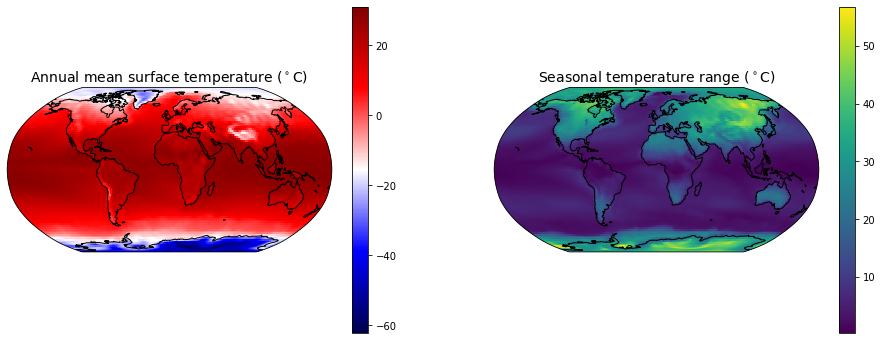

In [4]:
fig = plt.figure( figsize=(16,6) )

ax1 = fig.add_subplot(1,2,1, projection=ccrs.Robinson())
cax1 = ax1.pcolormesh(lon_ncep, lat_ncep, meanTs, cmap=plt.cm.seismic , transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(cax1)
ax1.set_title('Annual mean surface temperature ($^\circ$C)', fontsize=14 )

ax2 = fig.add_subplot(1,2,2, projection=ccrs.Robinson())
cax2 = ax2.pcolormesh(lon_ncep, lat_ncep, maxTs - minTs, transform=ccrs.PlateCarree() )
cbar2 = plt.colorbar(cax2)
ax2.set_title('Seasonal temperature range ($^\circ$C)', fontsize=14)

for ax in [ax1,ax2]:
    #ax.contour( lon_cesm, lat_cesm, topo.variables['LANDFRAC'][:], [0.5], colors='k');
    #ax.set_xlabel('Longitude', fontsize=14 ); ax.set_ylabel('Latitude', fontsize=14 )
    ax.coastlines()

Make a contour plot of the zonal mean temperature as a function of time of year

Text(0.5, 1.0, 'Zonal mean surface temperature (degC)')

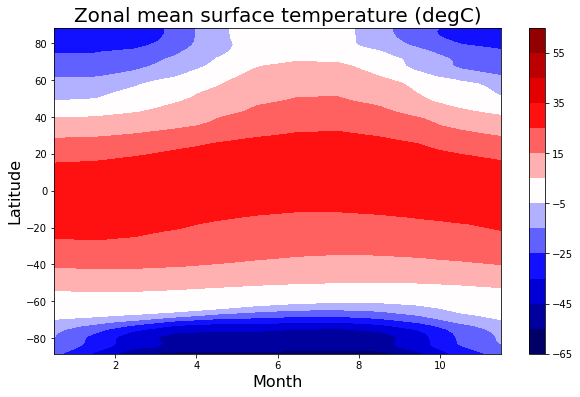

In [5]:
Tmax = 65; Tmin = -Tmax; delT = 10
clevels = np.arange(Tmin,Tmax+delT,delT)
fig_zonobs, ax = plt.subplots( figsize=(10,6) )
cax = ax.contourf(np.arange(12)+0.5, lat_ncep, 
                  Ts_ncep.mean(dim='lon').transpose(), levels=clevels, 
                  cmap=plt.cm.seismic, vmin=Tmin, vmax=Tmax)
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16 )
cbar = plt.colorbar(cax)
ax.set_title('Zonal mean surface temperature (degC)', fontsize=20)

## Exploring the amplitude of the seasonal cycle with an EBM

We are looking at the 1D (zonally averaged) energy balance model with diffusive heat transport. The equation is

$C \frac{\partial T(\phi,t)}{\partial t} = \big(1-\alpha\big) Q(\phi,t) - \Big(A+B T(\phi,t) \Big) + 
\frac{K}{\cos\phi} \frac{\partial}{\partial \phi} \bigg( \cos\phi \frac{\partial T}{\partial \phi} \bigg)$

and the code in `climlab.EBM_seasonal` solves this equation numerically.

One handy feature of `climlab` process code: the function `integrate_years()` automatically calculates the time averaged temperature. So if we run it for exactly one year, we get the annual mean temperature saved in the field `T_timeave`.

We will look at the seasonal cycle of temperature in three different models with different heat capacities (which we express through an equivalent depth of water in meters):

In [6]:
model1 = climlab.EBM_seasonal()
model1.integrate_years(1, verbose=True)

water_depths = np.array([2., 10., 50.])

num_depths = water_depths.size
Tann = np.empty( [model1.lat.size, num_depths] )
models = []

for n in range(num_depths):
    models.append(climlab.EBM_seasonal(water_depth=water_depths[n]))
    models[n].integrate_years(20., verbose=False )
    models[n].integrate_years(1., verbose=False)
    Tann[:,n] = np.squeeze(models[n].timeave['Ts'])

Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9999999999999991 years.


All models should have the same annual mean temperature:

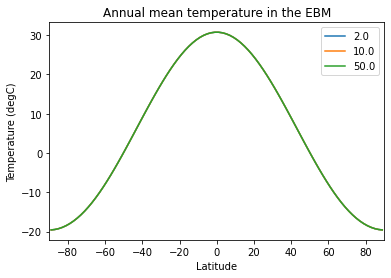

In [7]:
lat = model1.lat

plt.plot(lat, Tann)
plt.xlim(-90,90)
plt.xlabel('Latitude')
plt.ylabel('Temperature (degC)')
plt.title('Annual mean temperature in the EBM')
plt.legend( water_depths.astype(str) )
plt.show()

There is no automatic function in `climlab.EBM` to keep track of minimum and maximum temperatures (though we might add that in the future!)

Instead we'll step through one year "by hand" and save all the temperatures.

In [8]:
num_steps_per_year = int(model1.time['num_steps_per_year'])
Tyear = np.empty((lat.size, num_steps_per_year, num_depths))
for n in range(num_depths):
    for m in range(num_steps_per_year):
        models[n].step_forward()
        Tyear[:,m,n] = np.squeeze(models[n].Ts)

Make a figure to compare the observed zonal mean seasonal temperature cycle to what we get from the EBM with different heat capacities:

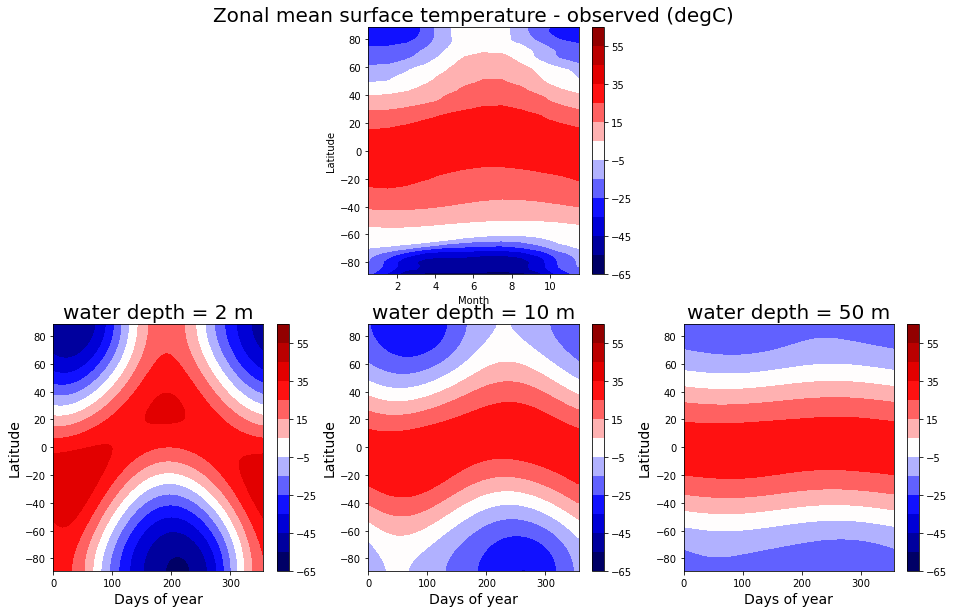

In [9]:
fig = plt.figure( figsize=(16,10) )

ax = fig.add_subplot(2,num_depths,2)
cax = ax.contourf(np.arange(12)+0.5, lat_ncep, 
                  Ts_ncep.mean(dim='lon').transpose(), 
                  levels=clevels, cmap=plt.cm.seismic, 
                  vmin=Tmin, vmax=Tmax)
ax.set_xlabel('Month')
ax.set_ylabel('Latitude')
cbar = plt.colorbar(cax)
ax.set_title('Zonal mean surface temperature - observed (degC)', fontsize=20)

for n in range(num_depths):
    ax = fig.add_subplot(2,num_depths,num_depths+n+1)
    cax = ax.contourf(4*np.arange(num_steps_per_year),
                      lat, Tyear[:,:,n], levels=clevels, 
                      cmap=plt.cm.seismic, vmin=Tmin, vmax=Tmax)
    cbar1 = plt.colorbar(cax)
    ax.set_title('water depth = %.0f m' %models[n].param['water_depth'], fontsize=20 )
    ax.set_xlabel('Days of year', fontsize=14 )
    ax.set_ylabel('Latitude', fontsize=14 )

Which one looks more realistic? Depends a bit on where you look. But overall, the observed seasonal cycle matches the 10 meter case best. The effective heat capacity governing the seasonal cycle of the zonal mean temperature is closer to 10 meters of water than to either 2 or 50 meters.

### Making an animation of the EBM solutions

In [10]:
def initial_figure(models):
    fig, axes = plt.subplots(1,len(models), figsize=(15,4))
    lines = []
    for n in range(len(models)):
        ax = axes[n]
        c1 = 'b'
        Tsline = ax.plot(lat, models[n].Ts, c1)[0]
        ax.set_title('water depth = %.0f m' %models[n].param['water_depth'], fontsize=20 )
        ax.set_xlabel('Latitude', fontsize=14 )
        if n == 0:
            ax.set_ylabel('Temperature', fontsize=14, color=c1 )
        ax.set_xlim([-90,90])
        ax.set_ylim([-60,60])
        for tl in ax.get_yticklabels():
            tl.set_color(c1)
        ax.grid()

        c2 = 'r'
        ax2 = ax.twinx()
        Qline = ax2.plot(lat, models[n].insolation, c2)[0]
        if n == 2:
            ax2.set_ylabel('Insolation (W m$^{-2}$)', color=c2, fontsize=14)
        for tl in ax2.get_yticklabels():
            tl.set_color(c2)
        ax2.set_xlim([-90,90])
        ax2.set_ylim([0,600])
        lines.append([Tsline, Qline])
    return fig, axes, lines

def animate(step, models, lines):
    for n, ebm in enumerate(models):
        ebm.step_forward()
        #  The rest of this is just updating the plot
        lines[n][0].set_ydata(ebm.Ts)
        lines[n][1].set_ydata(ebm.insolation)
    return lines

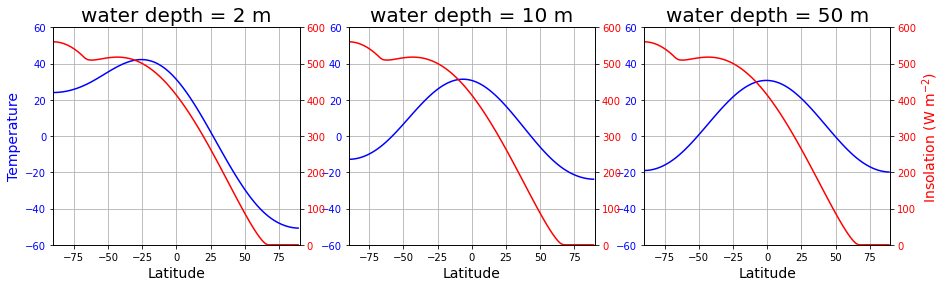

In [11]:
#  Plot initial data
fig, axes, lines = initial_figure(models)

In [12]:
#  Some imports needed to make and display animations
from IPython.display import HTML
from matplotlib import animation

num_steps = int(models[0].time['num_steps_per_year'])
ani = animation.FuncAnimation(fig, animate, 
        frames=num_steps,
        interval=80,
        fargs=(models, lines),
        )

In [13]:
HTML(ani.to_html5_video())

## The seasonal cycle for a planet with 90º obliquity

The EBM code uses our familiar `insolation.py` code to calculate insolation, and therefore it's easy to set up a model with different orbital parameters. Here is an example with **very** different orbital parameters: 90º obliquity. We looked at the distribution of insolation by latitude and season for this type of planet in the last homework.

In [14]:
orb_highobl = {'ecc':0., 'obliquity':90., 'long_peri':0.}
print(orb_highobl)
model_highobl = climlab.EBM_seasonal(orb=orb_highobl)
print(model_highobl.param['orb'])

{'ecc': 0.0, 'obliquity': 90.0, 'long_peri': 0.0}
{'ecc': 0.0, 'obliquity': 90.0, 'long_peri': 0.0}


Repeat the same procedure to calculate and store temperature throughout one year, after letting the models run out to equilibrium.

In [15]:
Tann_highobl = np.empty( [lat.size, num_depths] )
models_highobl = []

for n in range(num_depths):
    models_highobl.append(climlab.EBM_seasonal(water_depth=water_depths[n], orb=orb_highobl))
    models_highobl[n].integrate_years(40., verbose=False )
    models_highobl[n].integrate_years(1.)
    Tann_highobl[:,n] = np.squeeze(models_highobl[n].timeave['Ts'])

Tyear_highobl = np.empty([lat.size, num_steps_per_year, num_depths])
for n in range(num_depths):
    for m in range(num_steps_per_year):
        models_highobl[n].step_forward()
        Tyear_highobl[:,m,n] = np.squeeze(models_highobl[n].Ts)

Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 41.000000000002686 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 41.000000000002686 years.
Integrating for 90 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 41.000000000002686 years.


And plot the seasonal temperature cycle same as we did above:

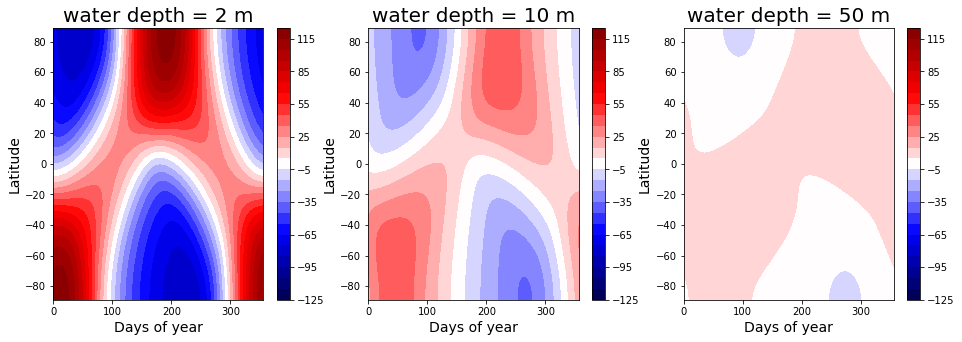

In [16]:
fig = plt.figure( figsize=(16,5) )
Tmax_highobl = 125; Tmin_highobl = -Tmax_highobl; delT_highobl = 10
clevels_highobl = np.arange(Tmin_highobl, Tmax_highobl+delT_highobl, delT_highobl)
for n in range(num_depths):
    ax = fig.add_subplot(1,num_depths,n+1)
    cax = ax.contourf( 4*np.arange(num_steps_per_year), lat, Tyear_highobl[:,:,n], 
        levels=clevels_highobl, cmap=plt.cm.seismic, vmin=Tmin_highobl, vmax=Tmax_highobl )
    cbar1 = plt.colorbar(cax)
    ax.set_title('water depth = %.0f m' %models[n].param['water_depth'], fontsize=20 )
    ax.set_xlabel('Days of year', fontsize=14 )
    ax.set_ylabel('Latitude', fontsize=14 )

Note that the temperature range is much larger than for the Earth-like case above (but same contour interval, 10 degC).

Why is the temperature so uniform in the north-south direction with 50 meters of water?

To see the reason, let's plot the annual mean insolation at 90º obliquity, alongside the present-day annual mean insolation:

In [17]:
lat2 = np.linspace(-90, 90, 181)
days = np.linspace(1.,50.)/50 * const.days_per_year
Q_present = climlab.solar.insolation.daily_insolation( lat2, days )
Q_highobl = climlab.solar.insolation.daily_insolation( lat2, days, orb_highobl )
Q_present_ann = np.mean( Q_present, axis=1 )
Q_highobl_ann = np.mean( Q_highobl, axis=1 )

Text(0.5, 1.0, 'Annual mean insolation for two different obliquities')

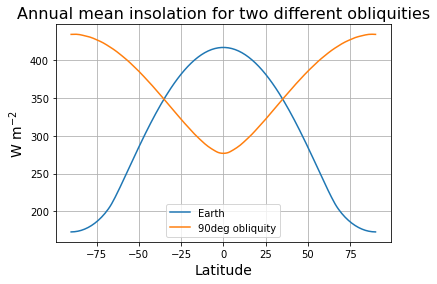

In [18]:
fig, ax = plt.subplots()
ax.plot( lat2, Q_present_ann, label='Earth' )
ax.plot( lat2, Q_highobl_ann, label='90deg obliquity' )
ax.grid()
ax.legend(loc='lower center')
ax.set_xlabel('Latitude', fontsize=14 )
ax.set_ylabel('W m$^{-2}$', fontsize=14 )
ax.set_title('Annual mean insolation for two different obliquities', fontsize=16)

Though this is a bit misleading, because our model prescribes an increase in albedo from the equator to the pole. So the absorbed shortwave gradients look even more different.

If you are interested in how ice-albedo feedback might work on a high-obliquity planet with a cold equator, then you might take a look at this paper:

[Rose, Cronin and Bitz (2017): Ice Caps and Ice Belts: The Effects of Obliquity on Ice−Albedo Feedback, The Astrophysical Journal 846, doi:10.3847/1538-4357/aa8306](https://iopscience.iop.org/article/10.3847/1538-4357/aa8306/meta)